In [1]:
# !pip install tensorflow==2.2.0
# !pip install numpy --upgrade
# !pip install sklearn --upgrade

In [2]:
# import numpy
!pip show tensorflow
# print (numpy.__version__)

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: opt-einsum, google-pasta, flatbuffers, numpy, grpcio, absl-py, astunparse, wrapt, h5py, six, tensorflow-estimator, gast, protobuf, keras-preprocessing, termcolor, typing-extensions, tensorboard, wheel
Required-by: tensorflow-cloud, fancyimpute


In [3]:
import re
import cv2
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import initializers, layers
from tensorflow import keras

import pickle
import os
import glob
import matplotlib.pyplot as plt
import time;
print("start")

start


#  TPU configuration

In [4]:
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)


DATASET = 'melanomasegmented'
# DATASET = 'unet-segmentedisic-20192020'
GCS_PATH = KaggleDatasets().get_gcs_path(DATASET)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


> # Hyperparameter tuning

In [5]:
SEED = 42
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
SIZE = [128,128]
LR = 0.00004
EPOCHS =50
WARMUP = 5
WEIGHT_DECAY = 0
LABEL_SMOOTHING = 0.05
TTA = 4
# 
INPUT_SHAPE = (128, 128, 3)
NUM_CLASS =2
ROUTING = 3
spread_loss_value=K.variable(0.2)

In [6]:
def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

seed_everything(SEED)
train_filenames = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
test_filenames = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

In [7]:
df_1 = pd.read_csv('/kaggle/input/model-melanoma-2020/submission.csv')
df_3b = pd.read_csv('/kaggle/input/melanoma-effnet-metdata/ensembled.csv')
df_4 = pd.read_csv('/kaggle/input/minmax-melanoma-9619/submission.csv')
df_5 = pd.read_csv('/kaggle/input/melanoma-2020-9648/submission_9648.csv')

In [8]:
def plot_images(np_images, titles = [], columns =3, figure_size = (24, 15)):
    count = len(np_images)
    rows = math.ceil(count / columns)
   

    fig = plt.figure(figsize=figure_size)
    subplots = []
    for index in range(count):
        subplots.append(fig.add_subplot(rows, columns, index + 1))
        if len(titles):
            subplots[-1].set_title(str(titles[index]))
        plt.imshow(np_images[index])

    plt.show()

In [9]:
train_filenames,valid_filenames = train_test_split(train_filenames,test_size = 0.05,random_state = SEED)

In [10]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3) 
    image = tf.cast(image, tf.float32)/255.0
    image = tf.reshape(image, [*SIZE, 3])
#     image = tf.image.resize(image, [28,28])
    return image

np.set_printoptions(threshold=np.inf)

def decode_image_png(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)/255.0
    image = tf.reshape(image, [*SIZE, 3])
#     image = tf.image.resize(image,[28,28])
    return image

def parseImageFromRawData(image_raw, shape=INPUT_SHAPE, type=tf.float32):
    image = tf.io.decode_raw(image_raw, type)
    image = tf.reshape(image, shape=shape)
    return image

def parse_example_unlabeled(example):  
    features = {'image': tf.io.FixedLenFeature([], tf.string),"image_name": tf.io.FixedLenFeature([], tf.string)}
    parsed_example = tf.io.parse_single_example(example, features=features)
    image = decode_image_png(parsed_example['image'])
    image_name = parsed_example['image_name']
    return (image, image_name)

def parse_example_labeled(example):  
    LABELED_TFREC_FORMAT ={
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),  }
    parsed_example = tf.io.parse_single_example(example,LABELED_TFREC_FORMAT)
    label = tf.cast(parsed_example['target'], tf.int32)
    image = decode_image_png(parsed_example['image'])
    return (image, label), (label, image)

def data_augment_unlabled(image,image_name, seed=SEED):
    image = tf.image.rot90(image,k=np.random.randint(4))
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    return (image,image_name)

def data_augment_labeled(image_label,label_image=None, seed=SEED):
    (image,label)=image_label
    image = tf.image.rot90(image,k=np.random.randint(4))
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    return (image, label),(label,image)

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    return (tf.data.TFRecordDataset(filenames,num_parallel_reads=AUTO) 
              .with_options(ignore_order)
               .map(parse_example_labeled if labeled
                    else parse_example_unlabeled, num_parallel_calls=AUTO))

                   
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


def plot_transform():
    plt.figure(figsize=(30,10))
    x = load_dataset(train_filenames, labeled=True).batch(BATCH_SIZE)
    for (image_label,label_image) in x:
        (images,labels)= image_label
        plot_images(images)
#        print(labels.numpy(),labels)
#        print("images.shape: ",images.shape)
        break
    
#     plt.imshow(images[40])

> # Visualizing Augmentation

<Figure size 2160x720 with 0 Axes>

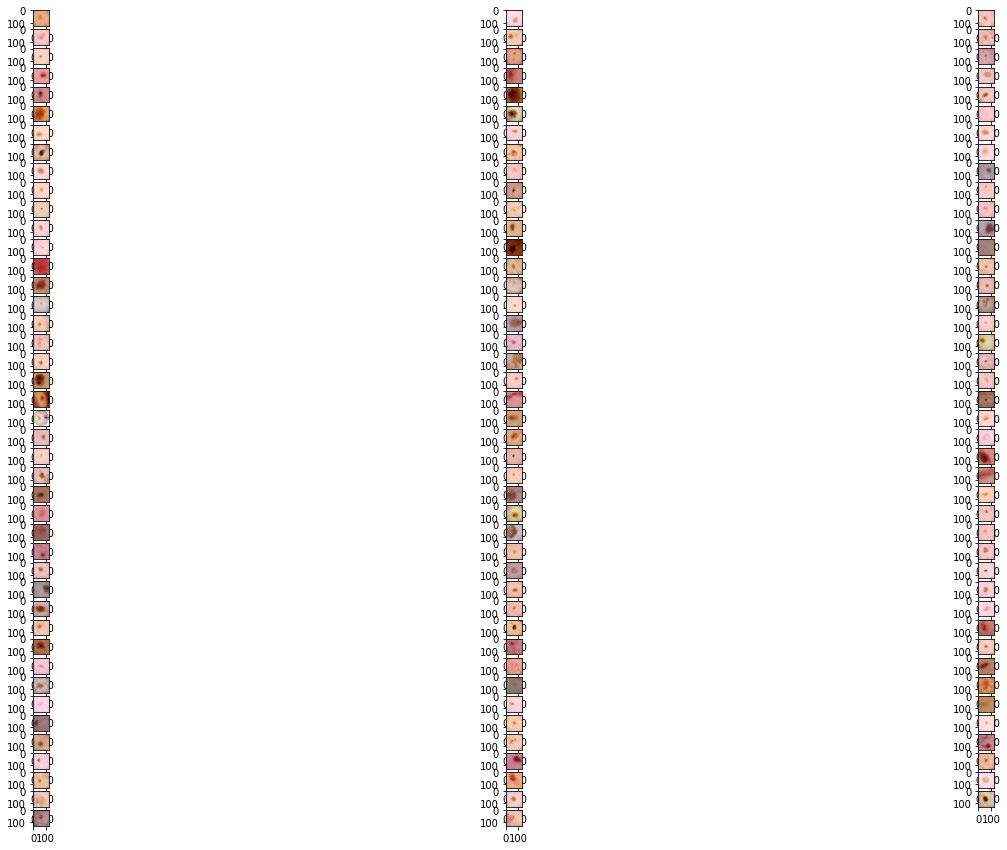

In [11]:
plot_transform()

# Segment all image

In [12]:

train_dataset = (load_dataset(train_filenames, labeled=True)
    .map(data_augment_labeled, num_parallel_calls=AUTO)
    .shuffle(SEED)
    .batch(BATCH_SIZE,drop_remainder=True)
    .repeat()
    .prefetch(AUTO))

valid_dataset = (load_dataset(valid_filenames, labeled=True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .cache()            
    .prefetch(AUTO))

> # Model,loss function

In [13]:
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        y_true =tf.bitcast(tf.cast(y_true, dtype=tf.float32), tf.float32)
        y_pred = tf.slice(y_pred, [0, 1], [y_pred.shape[0], 1]) #Only keep weights for melanoma
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [14]:
def margin_loss(y_true, y_pred):
    y_tobe =tf.bitcast(tf.cast(y_true, dtype=tf.int64), tf.int64)
    y_tobe = tf.one_hot(y_tobe, NUM_CLASS)
    y_tobe_correct = y_tobe
    y_tobe_wrong = 1 - y_tobe
    L = tf.math.multiply(y_tobe_correct, K.square(K.maximum(0., tf.math.subtract(0.9, y_pred)))) + \
        tf.math.multiply( y_tobe_wrong, K.square(K.maximum(0., tf.math.subtract(y_pred, 0.1))))
    return  K.mean(K.sum(L, 1))

In [15]:
def ssim_loss(image_true, image_rec):
    return  K.mean(tf.math.abs(tf.image.ssim(image_true, image_rec, max_val=1.0)))

In [16]:

class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        out = K.sqrt(K.sum(K.square(inputs), -1))
        return out

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        cnf = super(Length, self).get_config()
        return cnf


class Mask(layers.Layer):
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
#             mask = tf.bitcast(tf.cast(mask, dtype=tf.int8), tf.uint8)
            mask = tf.one_hot(mask,NUM_CLASS)
            mask = tf.reshape(mask, shape=(-1, NUM_CLASS))
        else:
            x = K.sqrt(K.sum(K.square(inputs), -1))
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))

        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            tf.print("in mask compute shape1 ")
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            tf.print("in mask compute shape2 ")
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        conf = super(Mask, self).get_config()
        return conf


def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale =( s_squared_norm / (1 + s_squared_norm) )/ K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


def reduce_sum(input_tensor, axis=None, keepdims=False):
    try:
        return tf.reduce_sum(input_tensor, axis=axis, keepdims=keepdims)
    except:
        return tf.reduce_sum(input_tensor, axis=axis, keep_dims=keepdims)


class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsule, dim_capsule, input_num_capsule,grid_size, routings=3,input_dim_capsule=8,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        print("self.num_capsule: ", self.num_capsule)
        self.dim_capsule = dim_capsule
        self.input_num_capsule = input_num_capsule
        self.routings = routings
        self.grid_size=grid_size
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.input_dim_capsule = input_dim_capsule

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        print(self.input_num_capsule, self.input_dim_capsule,self.num_capsule)
        self.W = self.add_weight(
            shape=[1, self.input_num_capsule // (self.grid_size *self.grid_size),2,1, 
                   self.input_dim_capsule, self.dim_capsule],
            initializer="random_normal",
            name='W')
        print("Shape of w : ", self.W.shape)

        self.built = True

    def call(self, inputs, training=None):
        input = tf.expand_dims(inputs, 2)
        weights = tf.tile(self.W, [1,1,1,self.grid_size *self.grid_size,1,1])
        input = tf.tile(input, [1,1, 2, 1, 1,1])
        u_hat = tf.matmul(input, weights, name="tf.matmulinputweights")
        u_hat = tf.transpose(u_hat, [0,1,3,2,4,5])
        u_hat=tf.reshape(u_hat,[-1,u_hat.shape[1]*u_hat.shape[2],u_hat.shape[3],u_hat.shape[4],u_hat.shape[5]])
        u_hat_stopped = tf.stop_gradient(u_hat, name='stop_gradient')
        
        b_IJ = tf.constant(np.zeros([1, self.input_num_capsule, self.num_capsule,1,1], dtype=np.float32))
        for r_iter in range(ROUTING):
            c_IJ = tf.nn.softmax(b_IJ, axis=2)
            if r_iter == 2:
                s_J = tf.matmul(c_IJ, u_hat, name="Mulc_IJu_hat")
                s_J = reduce_sum(s_J, axis=1, keepdims=True)  # + biases
                v_J = squash(s_J)
            elif r_iter < 2:  # Inner iterations, do not apply backpropagation
                s_J = tf.matmul(c_IJ,u_hat_stopped , name="Mulc_IJu_hat_stopped")
                s_J = reduce_sum(s_J, axis=1, keepdims=True)  # + biases
                v_J = squash(s_J)
                v_J_tiled = tf.tile(v_J, [1, self.input_num_capsule, 1, 1, 1])
                u_produce_v = reduce_sum(u_hat_stopped * v_J_tiled, axis=4, keepdims=True)
                b_IJ += u_produce_v
               
        v_J = tf.squeeze(v_J, axis=1)
        v_J = tf.squeeze(v_J, axis=2)
        return (v_J)

    def compute_output_shape(self, input_shape):
        # print(" compute_output_shape input_shape::::",input_shape.shape)
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        conf = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(conf.items()))

In [17]:
def createHintonCapsule():
    input_dim_capsule=8
    dim_capsule=16
    
    filter_multiplier=16
    grid_size= int(math.sqrt(filter_multiplier) * 2)

    x = layers.Input(shape=INPUT_SHAPE)
    print("x",x)
    conv1 = layers.Conv2D(filters=128, kernel_size=25, strides=(3,3), padding='valid', activation='swish', name='conv1')(x)
    print("conv1",conv1)
    conv2 = layers.Conv2D(filters=128, kernel_size=16, strides=(2,2), padding='valid', activation='swish', name='conv2')(conv1)
#     print("conv2",conv2)
    primary = layers.Conv2D(filters=input_dim_capsule*filter_multiplier, kernel_size=9,strides=1,padding='valid', activation='swish',name='primarycap_conv2d')(conv2)
    print("primary1:", primary)

    primary = layers.Reshape(target_shape=[-1,grid_size*grid_size,1, input_dim_capsule], name='primarycap_reshape')(primary)
    print("primary2:", primary)
    primary = layers.Lambda(squash, name='primarycap_squash')(primary)
    print("primary3:", primary)
    
    # input_num_capsule for size 28*28=1152 and size 128*128=100352  and size 256*256=460800
    digitcaps = CapsuleLayer(num_capsule=NUM_CLASS, input_num_capsule=100352 ,
                             dim_capsule=dim_capsule, routings=3,grid_size=grid_size,
                             input_dim_capsule=input_dim_capsule,
                             name='digitcaps')(primary)

    print("digitcaps:", digitcaps)

    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(1,), name='mask_input',dtype="int64")
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction
    print("shape of masked_by_y ", masked_by_y.shape)

    # Shared Decoder model in training and prediction
    decoder = tf.keras.models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_shape=(1, dim_capsule * NUM_CLASS)))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(INPUT_SHAPE), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=INPUT_SHAPE, name='out_recon'))
    decoder.summary()
    # Models for training and evaluation (prediction)
    train_model = tf.keras.models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = tf.keras.models.Model(x, [out_caps])
    return train_model, eval_model

In [18]:
def createWBCCapsule():
    x = layers.Input(shape=INPUT_SHAPE)
    conv1 = layers.Conv2D(filters=32, activation='relu', kernel_size=7, strides=2, padding='same', name='conv1')(x)
    conv2 = layers.Conv2D(filters=128, activation='relu', kernel_size=5, strides=2, padding='same', name='conv2')(conv1)
    primary = layers.Conv2D(128, kernel_size=5, strides=1, padding='same', name='primarycap_conv2d')(conv2)
    print("primary before reshape:::::::", primary.shape)
    primary = layers.Reshape(target_shape=[-1, 8], name='primarycap_reshape')(primary)
    print("primary:::::::", primary.shape)
    primary = layers.Lambda(squash, name='primarycap_squash')(primary)
    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=NUM_CLASS,
                             input_num_capsule=INPUT_SHAPE[0] * INPUT_SHAPE[1],
                             dim_capsule=64, routings=3, name='digitcaps')(primary)

    print("digitcaps:::::::", digitcaps.shape)
    out_caps = Length(name='capsnet')(digitcaps)
    print("out_caps:::::::", out_caps.shape)

    # Decoder network.
    y = layers.Input(shape=(1,), name='mask_input',dtype="int64")
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction
    print("shape of masked_by_y ", masked_by_y.shape)

    # Shared Decoder model in training and prediction
    decoder_input = layers.Input(shape=(NUM_CLASS, 64 *NUM_CLASS))
    decoder_out = layers.Dense(64, activation='relu', input_shape=(1, 16 * NUM_CLASS))(decoder_input)
    decoder_out = layers.Dense(256, activation='relu')(decoder_out)
    decoder_out = layers.Dense(np.prod(INPUT_SHAPE), activation='sigmoid')(decoder_out)
    decoder_out = layers.Reshape(target_shape=INPUT_SHAPE, name='out_recon')(decoder_out)

    decoder = tf.keras.models.Model(decoder_input, [decoder_out])
    decoder.summary()
    # Models for training and evaluation (prediction)
    model = tf.keras.models.Model([x, y], [out_caps, decoder(masked_by_y)])
    # eval_model = tf.keras.models.Model(x, [out_caps, decoder(masked)])
    eval_model = tf.keras.models.Model(x, [out_caps])

    return model, eval_model

In [19]:
class change_spread_loss_coeff_callback(keras.callbacks.Callback):
    def __init__(self, spread_loss_value):
        self.spread_loss_value = spread_loss_value  
    def on_epoch_end(self, epoch, logs=None):
      total_increase=0.95 -0.2
      percent_done=(epoch)/EPOCHS
      K.set_value(self.spread_loss_value, K.get_value(self.spread_loss_value) + (percent_done*total_increase) )
    
spread_loss_instance = change_spread_loss_coeff_callback(spread_loss_value)    

def spread_loss(y_true, y_pred):
    y_tobe =tf.bitcast(tf.cast(y_true, dtype=tf.int64), tf.int64)
    y_tobe = tf.one_hot(y_tobe, NUM_CLASS)
    y_tobe = tf.squeeze(y_tobe,axis=1)
    y_tobe_correct = y_tobe
    y_tobe_wrong = 1- y_tobe
    y_pred_correct =tf.math.multiply(y_tobe_correct,y_pred)
    y_pred_wrong =tf.math.multiply(-1 * y_tobe_wrong,y_pred)
    loss = tf.reduce_sum(y_pred_correct+y_pred_wrong,axis=-1)
    loss = tf.math.square(K.maximum(0.,spread_loss_instance.spread_loss_value - loss))
    loss = K.mean(loss)
    return  loss

In [20]:
with strategy.scope():
    (model, eval_model) = createHintonCapsule()
#     model.summary()
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01)
#     loss=spread_loss
    model.compile(optimizer='adam',
                    loss=[loss, 'mse'],
                    loss_weights=[1., 0.0005 * INPUT_SHAPE[0] * INPUT_SHAPE[1]],
                    metrics=[{'capsnet': 'accuracy'},tf.keras.metrics.AUC(name='auc')]
                 )

x KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
conv1 KerasTensor(type_spec=TensorSpec(shape=(None, 35, 35, 128), dtype=tf.float32, name=None), name='conv1/IdentityN:0', description="created by layer 'conv1'")
primary1: KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 128), dtype=tf.float32, name=None), name='primarycap_conv2d/IdentityN:0', description="created by layer 'primarycap_conv2d'")
primary2: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 64, 1, 8), dtype=tf.float32, name=None), name='primarycap_reshape/Reshape:0', description="created by layer 'primarycap_reshape'")
primary3: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 64, 1, 8), dtype=tf.float32, name=None), name='primarycap_squash/mul:0', description="created by layer 'primarycap_squash'")
self.num_capsule:  2
100352 8 2
Shape of w :  (1, 1568, 2, 1, 8, 16)
digitcaps: KerasTensor(type_spec=TensorSpec(shape=(N

> # Scheduler

*  Modified version of the [get_cosine_schedule_with_warmup](https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup) from huggingface.

In [21]:
def get_cosine_schedule_with_warmup(lr,num_warmup_steps, num_training_steps, num_cycles=0.5):

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return (float(epoch) / float(max(1, num_warmup_steps))) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

lr_schedule= get_cosine_schedule_with_warmup(lr=LR,num_warmup_steps=WARMUP,num_training_steps=EPOCHS)

> # Training

In [22]:

def train():
        STEPS_PER_EPOCH = count_data_items(train_filenames) // BATCH_SIZE
        history =  model.fit(
            train_dataset, 
            epochs=EPOCHS, 
#             callbacks=[tf.keras.callbacks.TerminateOnNaN()],
#             callbacks=[lr_schedule,tf.keras.callbacks.TerminateOnNaN()],
           callbacks=[lr_schedule],
#             callbacks=[spread_loss_instance],
            steps_per_epoch=STEPS_PER_EPOCH,
            workers=8,
            use_multiprocessing=True,
            validation_data=valid_dataset)
#         print(model.history.history)
        history_record= {'Epoch':range(1,EPOCHS+1),
                        'loss': model.history.history['loss'],
                         'capsnet_loss': model.history.history['capsnet_loss'],
                        'decoder_loss':model.history.history['decoder_loss'],
                         'capsnet_accuracy':model.history.history['capsnet_accuracy'],
                         'decoder_auc':model.history.history['decoder_auc'],
                         'val_loss':model.history.history['val_loss'],
                         'val_capsnet_loss':model.history.history['val_capsnet_loss'],
                         'val_decoder_loss':model.history.history['val_decoder_loss'],
                         'val_capsnet_accuracy':model.history.history['val_capsnet_accuracy'],
                         'val_decoder_auc':model.history.history['val_decoder_auc'],
                        }
        result = pd.DataFrame(data=history_record)
        result.to_csv('history_record.csv', index=False)
        string = 'Train acc:{:.4f} Train loss:{:.4f} , Val acc:{:.4f} Val loss:{:.4f} '.format( \
            model.history.history['capsnet_accuracy'][-1],model.history.history['loss'][-1],\
            model.history.history['val_capsnet_accuracy'][-1],model.history.history['val_loss'][-1])

        return string

In [23]:
train()

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0.
422/422 [==============================] - 130s 232ms/step - loss: 1.0382 - capsnet_loss: 0.4953 - decoder_loss: 0.0663 - capsnet_accuracy: 0.8857 - decoder_auc: 0.5000 - val_loss: 0.9836 - val_capsnet_loss: 0.4130 - val_decoder_loss: 0.0697 - val_capsnet_accuracy: 0.9081 - val_decoder_auc: 0.5000
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 8.000000000000001e-06.
422/422 [==============================] - 91s 216ms/step - loss: 0.9004 - capsnet_loss: 0.3632 - decoder_loss: 0.0656 - capsnet_accuracy: 0.5100 - decoder_auc: 0.5225 - val_loss: 0.7881 - val_capsnet_loss: 0.2571 - val_decoder_loss: 0.0648 - val_capsnet_accuracy: 0.8620 - val_decoder_auc: 0.4387
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 1.6000000000000003e-05.
422/422 [==============================] - 91s 216ms/step - loss: 0.7207 - capsnet_loss: 0.3200 - decoder_loss: 0.0489 - capsnet_acc

'Train acc:0.8490 Train loss:0.2582 , Val acc:0.8190 Val loss:0.2989 '

In [24]:
eval_model.save_weights("saved_weights/" + str(time.time()))

> # Plotting training loss, accuracy and roc

In [25]:
def display_training_curves(training, validation, title, subplot):
  
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(20,35), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

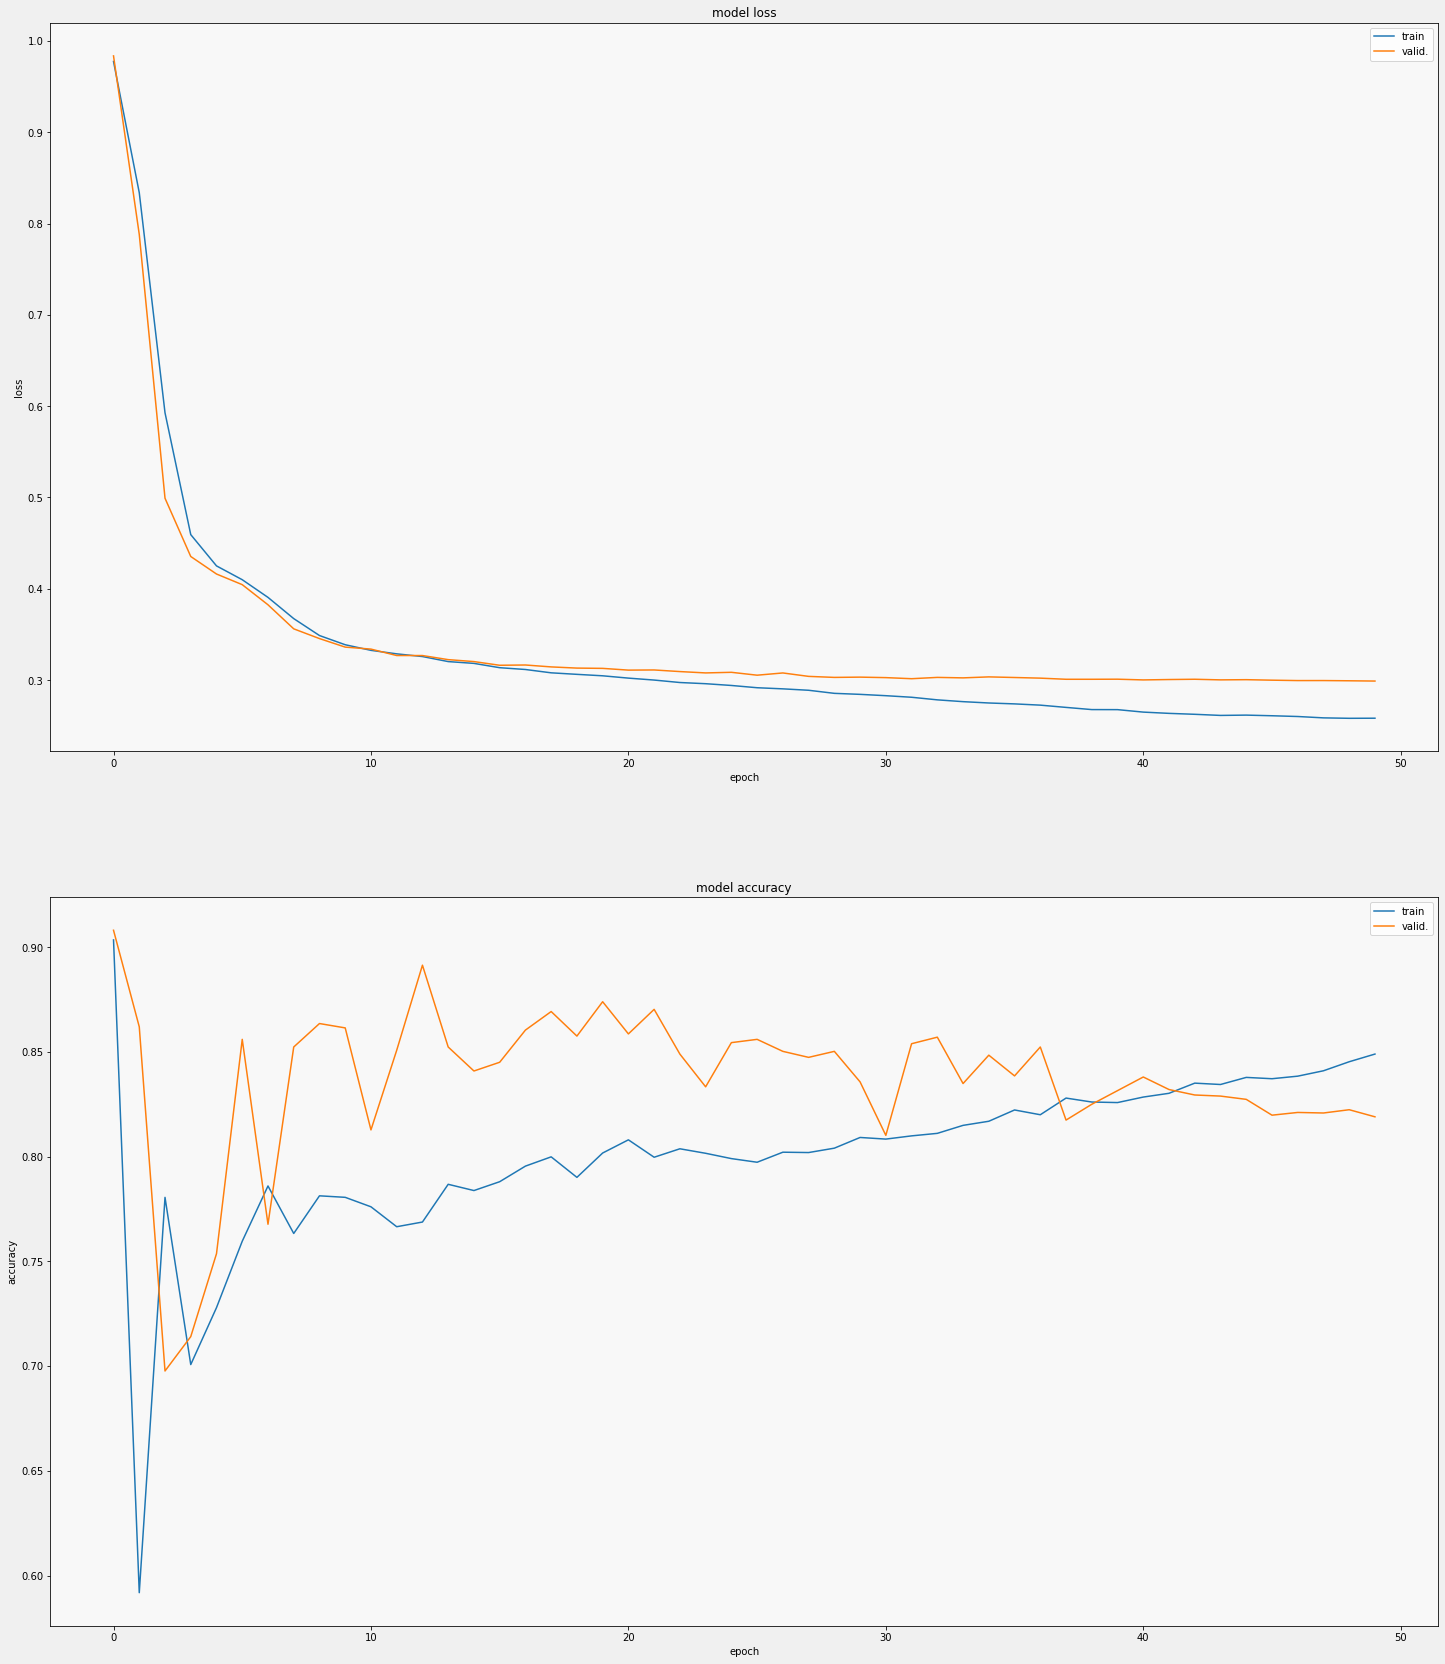

In [26]:
display_training_curves(
    model.history.history['loss'], 
    model.history.history['val_loss'], 
    'loss', 311)
display_training_curves(
    model.history.history['capsnet_accuracy'], 
    model.history.history['val_capsnet_accuracy'], 
    'accuracy', 312)
# display_training_curves(
#     model.history.history['auc'], 
#     model.history.history['val_auc'], 
#     'auc', 313)

> # Prediction with TTA

In [27]:
def getImages(image,image_name):
    return (image)

def getImageNames(image,image_name):
    return (image_name)

num_test_images = count_data_items(test_filenames)
submission_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
for i in range(TTA):
    test_dataset = (load_dataset(test_filenames, labeled=False,ordered=True)
    .map(data_augment_unlabled, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE))
    test_dataset_images = test_dataset.map(getImages)
    test_dataset_image_name = test_dataset.map(getImageNames).unbatch()
    test_ids = next(iter(test_dataset_image_name.batch(num_test_images))).numpy().astype('U')
    all_preds = eval_model.predict(test_dataset_images, verbose=1)
    all_preds=np.concatenate(all_preds)
    malig_preds=[]
    step=2
    start=1
    for j in range(start,len(all_preds),step):
        malig_preds.append(all_preds[j])
    pred_df = pd.DataFrame({'image_name': test_ids, 'target': malig_preds})
    temp = submission_df.copy()
    del temp['target']
    submission_df['target'] += temp.merge(pred_df,on="image_name")['target']/TTA

86/86 [==============================] - 7s 69ms/step


> # Submission

In [28]:
submission_df.to_csv('capsule.csv', index=False)
pd.Series(np.round(submission_df['target'].values)).value_counts()
submission_df

,image_name,target
0,ISIC_0052060,0.040340
1,ISIC_0052349,0.016236
2,ISIC_0058510,0.005085
3,ISIC_0073313,0.004824
4,ISIC_0073502,0.016553
...,...,...
10977,ISIC_9992485,0.017316
10978,ISIC_9996992,0.034549
10979,ISIC_9997917,0.251884
10980,ISIC_9998234,0.017676


# MetaData

In [29]:
submission2_df = df_1.copy()
submission2_df['target'] = 0.075 * df_1['target'] + 0.1 * df_3b['target'] + 0.375 * df_4['target'] + 0.45 * df_5['target']

In [30]:
submission2_df.to_csv('metadata.csv', index=False)
submission2_df

,image_name,target
0,ISIC_0052060,0.021669
1,ISIC_0052349,0.017856
2,ISIC_0058510,0.023512
3,ISIC_0073313,0.018779
4,ISIC_0073502,0.019920
...,...,...
10977,ISIC_9992485,0.016272
10978,ISIC_9996992,0.024099
10979,ISIC_9997917,0.043192
10980,ISIC_9998234,0.024904


# **Merge**

In [31]:
result = df_1.copy()
result['target']=(submission2_df['target'] + submission_df['target'])/2.0 
result.to_csv('capsule_meta.csv', index=False)
result

,image_name,target
0,ISIC_0052060,0.031005
1,ISIC_0052349,0.017046
2,ISIC_0058510,0.014298
3,ISIC_0073313,0.011801
4,ISIC_0073502,0.018236
...,...,...
10977,ISIC_9992485,0.016794
10978,ISIC_9996992,0.029324
10979,ISIC_9997917,0.147538
10980,ISIC_9998234,0.021290
